In [1]:
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})

In [2]:
SCORES_FILE = "../../results/shaping-eval/tamaraw/scores.csv"
OUTPUT_FILE = pathlib.Path("/tmp/plot.png")
MIN_PKT_SIZE = 150

if "snakemake" in globals():
    SCORES_FILE = snakemake.input[0]
    OUTPUT_FILE = pathlib.Path(snakemake.output[0])
    MIN_PKT_SIZE = snakemake.params.get("min_pkt_size", 0)

In [3]:
data = pd.melt(pd.read_csv(SCORES_FILE), id_vars=["sample", "rate", "dir", "min_pkt_size"], var_name="metric")
data = data[data["min_pkt_size"] == MIN_PKT_SIZE]
data

,sample,rate,dir,min_pkt_size,metric,value
1,results/shaping-eval/tamaraw/dataset/0006/0_0,1ms,in,150,pearsonr,-0.029151
3,results/shaping-eval/tamaraw/dataset/0006/0_0,1ms,out,150,pearsonr,0.270718
5,results/shaping-eval/tamaraw/dataset/0006/0_0,5ms,in,150,pearsonr,0.052453
7,results/shaping-eval/tamaraw/dataset/0006/0_0,5ms,out,150,pearsonr,0.159370
9,results/shaping-eval/tamaraw/dataset/0006/0_0,25ms,in,150,pearsonr,0.127384
...,...,...,...,...,...,...
631,results/shaping-eval/tamaraw/dataset/0012/2_0,5ms,out,150,euclidean,-0.430205
633,results/shaping-eval/tamaraw/dataset/0012/2_0,25ms,in,150,euclidean,0.914873
635,results/shaping-eval/tamaraw/dataset/0012/2_0,25ms,out,150,euclidean,0.083223
637,results/shaping-eval/tamaraw/dataset/0012/2_0,50ms,in,150,euclidean,0.925697


In [4]:
RATE_COL = "Sampling rate (ms)"

plot_data = data.rename(columns={
    "dir": "Direction",
    "rate": RATE_COL,
    "value": "Score",
})
plot_data.loc[:, "Direction"] = plot_data["Direction"].replace({
    "in": "Server → Client", 
    "out": "Client → Server",
})
plot_data[RATE_COL] = plot_data[RATE_COL].apply(lambda x: int(x[:-2]))

plot_data

,sample,Sampling rate (ms),Direction,min_pkt_size,metric,Score
1,results/shaping-eval/tamaraw/dataset/0006/0_0,1,Server → Client,150,pearsonr,-0.029151
3,results/shaping-eval/tamaraw/dataset/0006/0_0,1,Client → Server,150,pearsonr,0.270718
5,results/shaping-eval/tamaraw/dataset/0006/0_0,5,Server → Client,150,pearsonr,0.052453
7,results/shaping-eval/tamaraw/dataset/0006/0_0,5,Client → Server,150,pearsonr,0.159370
9,results/shaping-eval/tamaraw/dataset/0006/0_0,25,Server → Client,150,pearsonr,0.127384
...,...,...,...,...,...,...
631,results/shaping-eval/tamaraw/dataset/0012/2_0,5,Client → Server,150,euclidean,-0.430205
633,results/shaping-eval/tamaraw/dataset/0012/2_0,25,Server → Client,150,euclidean,0.914873
635,results/shaping-eval/tamaraw/dataset/0012/2_0,25,Client → Server,150,euclidean,0.083223
637,results/shaping-eval/tamaraw/dataset/0012/2_0,50,Server → Client,150,euclidean,0.925697


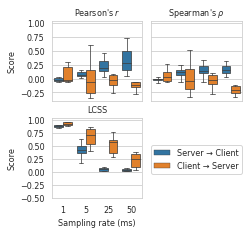

In [5]:
metric_label = {
    "pearsonr": "Pearson's $r$", 
    "spearmanr": "Spearman's $\\rho{}$",
    "lcss": "LCSS",
    "euclidean": "Scaled Euclidean"
}

def plot(data):
    fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(3.5, 3.3))
    axes[1, 1].remove()
    
    for metric, ax in zip(["pearsonr", "spearmanr", "lcss"], axes.ravel()):
        plot_data = data[data["metric"] == metric]
        sns.boxplot(data=plot_data, x=RATE_COL, y="Score", hue="Direction", showfliers=False, ax=ax, linewidth=0.75)
        ax.get_legend().remove()
        ax.set_title(metric_label[metric])
        ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5, .75, 1.0])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, .32), ncol=1)
    
    for ax in axes[0]:
        ax.set_xlabel(None)
    for ax in axes[:, 1:].ravel():
        ax.set_ylabel(None)
    fig.tight_layout(h_pad=0.5)
    
    return fig

fig = plot(plot_data)
fig.savefig(OUTPUT_FILE.with_suffix(".png"), bbox_inches="tight", dpi=150)
fig.savefig(OUTPUT_FILE.with_suffix(".pgf"), backend="pgf", bbox_inches="tight")